# Visualising matching outputs

We use the output from the example at https://dedupeio.github.io/dedupe-examples/docs/csv_example.html

The output is a set of records, where potential duplicates are grouped into clusters with a confidence score per record.

In [8]:
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

matching_output_file = 'csv_example/csv_example_output.csv'
match_columns = ['Cluster ID', 'confidence_score', 'Id']

df = pd.read_csv(matching_output_file)
df[match_columns].head()

,Cluster ID,confidence_score,Id
0,0,0.817328,0
1,0,0.817328,1
2,126,0.895183,2
3,126,0.895183,3
4,6,0.895183,4


Each row assigns a single cluster ID to a record

In [9]:
'count of records and unique records', len(df.index), len(df['Id'].unique())

('count of records and unique records', 3337, 3337)

Further columns include original record attributes

In [10]:
df.columns

Index(['Cluster ID', 'confidence_score', 'Id', 'Source', 'Site name',
       'Address', 'Zip', 'Phone', 'Fax', 'Program Name', 'Length of Day',
       'IDHS Provider ID', 'Agency', 'Neighborhood', 'Funded Enrollment',
       'Program Option', 'Number per Site EHS', 'Number per Site HS',
       'Director', 'Head Start Fund', 'Eearly Head Start Fund', 'CC fund',
       'Progmod', 'Website', 'Executive Director', 'Center Director',
       'ECE Available Programs', 'NAEYC Valid Until', 'NAEYC Program Id',
       'Email Address', 'Ounce of Prevention Description',
       'Purple binder service type', 'Column', 'Column2'],
      dtype='object')

## Cluster sizes

In [11]:
cluster_id = df['Cluster ID']
cluster_unique_counts = np.unique(cluster_id, return_counts=True)
sort_ids = np.argsort(cluster_unique_counts[1])
max_cluster_size = cluster_unique_counts[1][sort_ids[-1]]
cluster_count = len(cluster_unique_counts[0])
'count of clusters', cluster_count

('count of clusters', 1514)

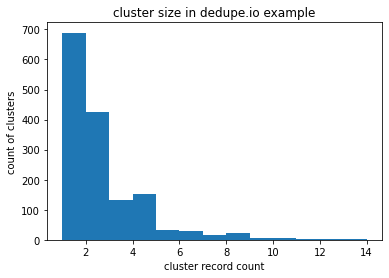

In [12]:
plt.hist(cluster_unique_counts[1], bins=(max_cluster_size - 1))
plt.title('cluster size in dedupe.io example')
plt.ylabel('count of clusters')
plt.xlabel('cluster record count')
plt.show()

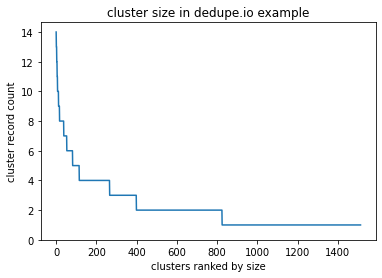

In [13]:
plt.plot(np.flip(cluster_unique_counts[1][sort_ids]))
plt.ylim(bottom=0)
plt.title('cluster size in dedupe.io example')
plt.ylabel('cluster record count')
plt.xlabel('clusters ranked by size')
plt.show()

## Confidence per record

In [14]:
cluster_confidence = df['confidence_score']

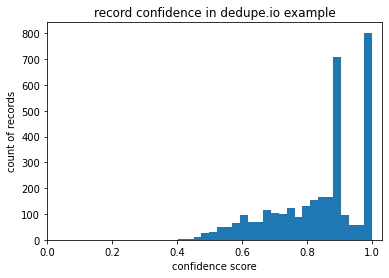

In [15]:
plt.hist(cluster_confidence, bins=25)
plt.title('record confidence in dedupe.io example')
plt.ylabel('count of records')
plt.xlim(left=0)
plt.xlabel('confidence score')
plt.show()

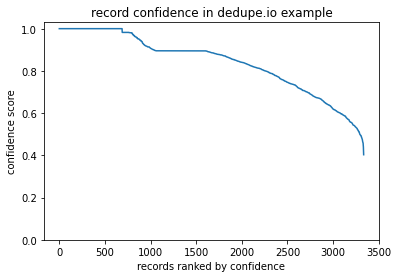

In [16]:
plt.plot(np.flip(np.sort(cluster_confidence)))
plt.ylim(bottom=0)
plt.title('record confidence in dedupe.io example')
plt.ylabel('confidence score')
plt.xlabel('records ranked by confidence')
plt.show()

## Relationship of cluster size and confidence

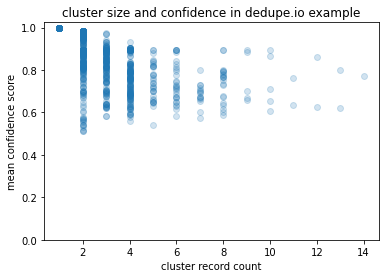

In [17]:
conf_sort = df.groupby('Cluster ID').mean()['confidence_score'][cluster_unique_counts[0][sort_ids]]
plt.scatter(cluster_unique_counts[1][sort_ids], conf_sort, alpha=0.2)
plt.ylim(bottom=0)
plt.title('cluster size and confidence in dedupe.io example')
plt.ylabel('mean confidence score')
plt.xlabel('cluster record count')
plt.show()

## Visualising a big cluster

In [18]:
big_cluster = df[df['Cluster ID'] == sort_ids[-1]][match_columns]
'big cluster record count', len(big_cluster.index)

('big cluster record count', 14)

In [19]:
g1 = nx.Graph()
cluster_nodes = [f"cluster {i}" for i in big_cluster['Cluster ID']]
record_nodes = [f"record {i}" for i in big_cluster['Id']]
edges = list(zip(cluster_nodes, record_nodes))
g1.add_edges_from(edges)
widths = np.array(big_cluster['confidence_score'])
conf_attr = {e: str(w)[:4] for e, w in zip(list(edges), widths)}
nx.set_edge_attributes(g1, conf_attr, 'confidence')

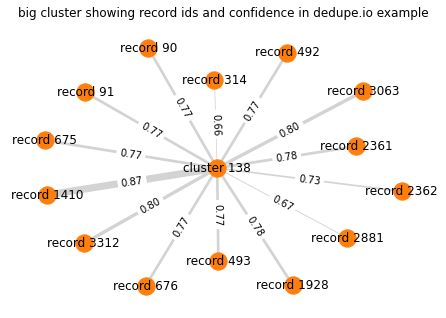

In [20]:
pos=nx.spring_layout(g1)
nx.draw(g1, pos=pos, width=(20 * np.power(widths, 8)), with_labels=True, 
       node_color='tab:orange', edge_color='lightgrey')
nx.draw_networkx_edge_labels(g1, pos, edge_labels=conf_attr)
plt.title('big cluster showing record ids and confidence in dedupe.io example')
plt.show()

## Visualising all clusters

Here we make direct connections between all pairs of records in a cluster

In [21]:
def cluster_graph(df, subset_length):
    g = nx.Graph()
    for i in df['Cluster ID'].unique()[:subset_length]:
        cluster = df[df['Cluster ID'] == i][match_columns]
        if len(cluster['Id'].index) == 1:
            g.add_node(cluster['Id'].iloc[0])
        else:
            edges = list(itertools.combinations(cluster['Id'], 2))
            g.add_edges_from(edges)
            mean_conf = cluster['confidence_score'].mean()
            conf_attr = {e: str(w)[:4] for e, w in zip(edges, [mean_conf] * len(edges))}
            nx.set_edge_attributes(g, conf_attr, 'confidence')
    return g

In [22]:
def plot_cluster_graph(g, title):
    plt.figure(figsize=(32, 18))
    max_degree = nx.degree_histogram(g)[-1]
    degnorm = np.array([nx.degree(g)[n] / max_degree for n in g.nodes])
    colors = [mpl.cm.viridis_r(d) for d in degnorm]  
    nx.draw(g, node_size=40*degnorm+20, node_color=colors,
            with_labels=False, edge_color='lightgrey')
    plt.title(title, fontsize=24)
    plt.show()

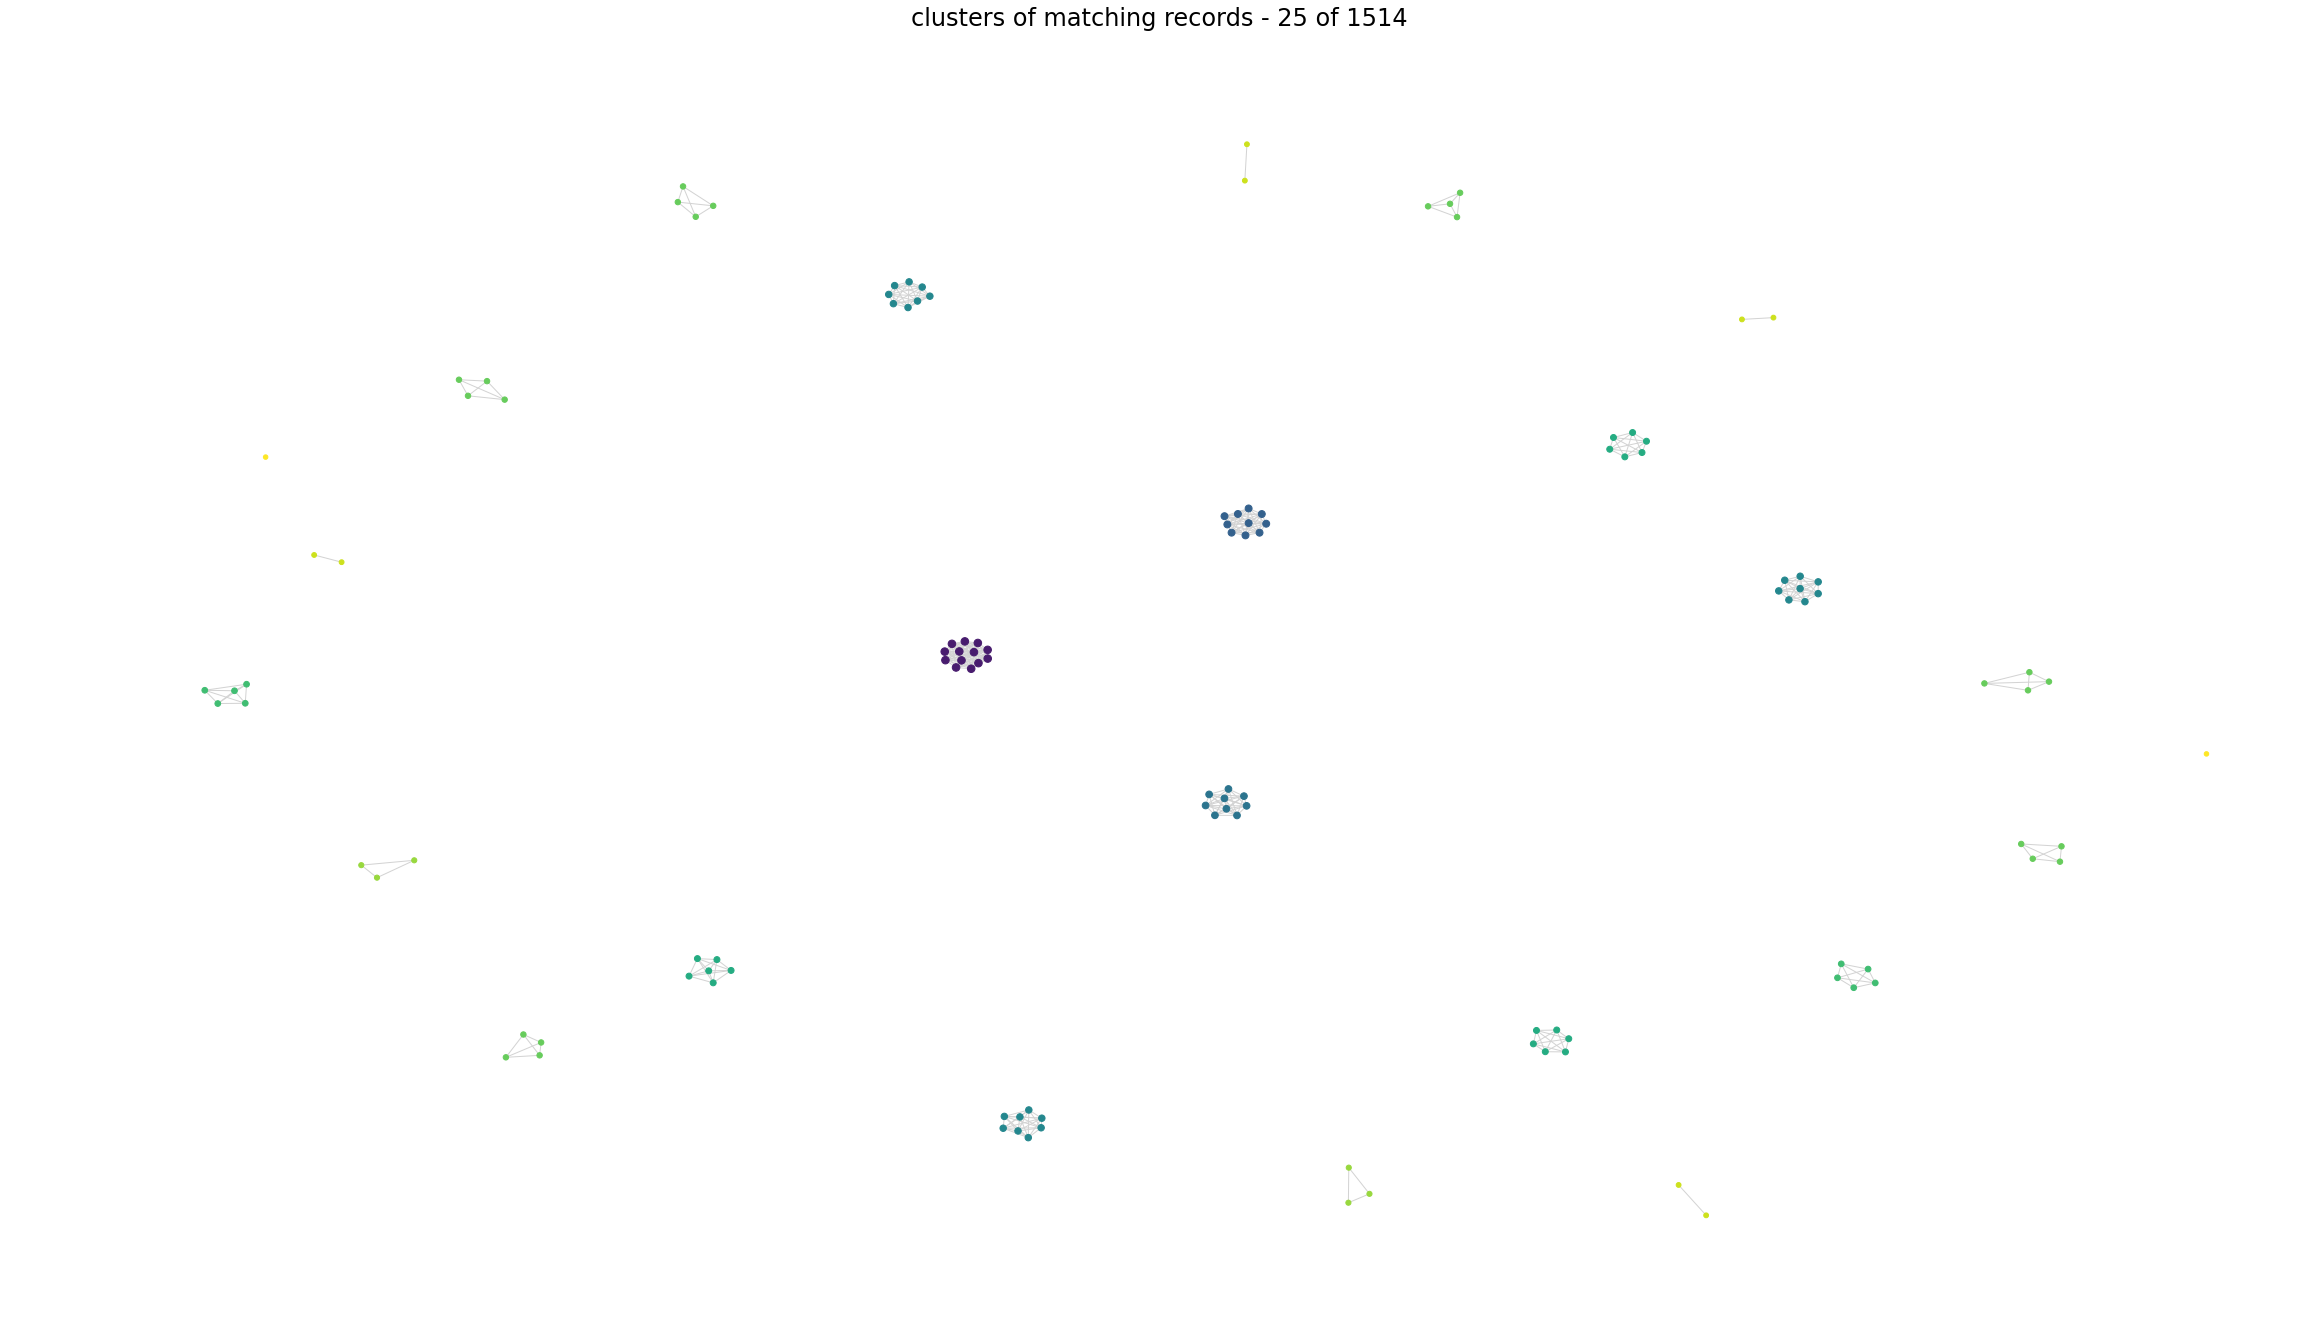

In [23]:
subset_length = 25
title = f'clusters of matching records - {subset_length} of {cluster_count}'
plot_cluster_graph(cluster_graph(df, subset_length), title)

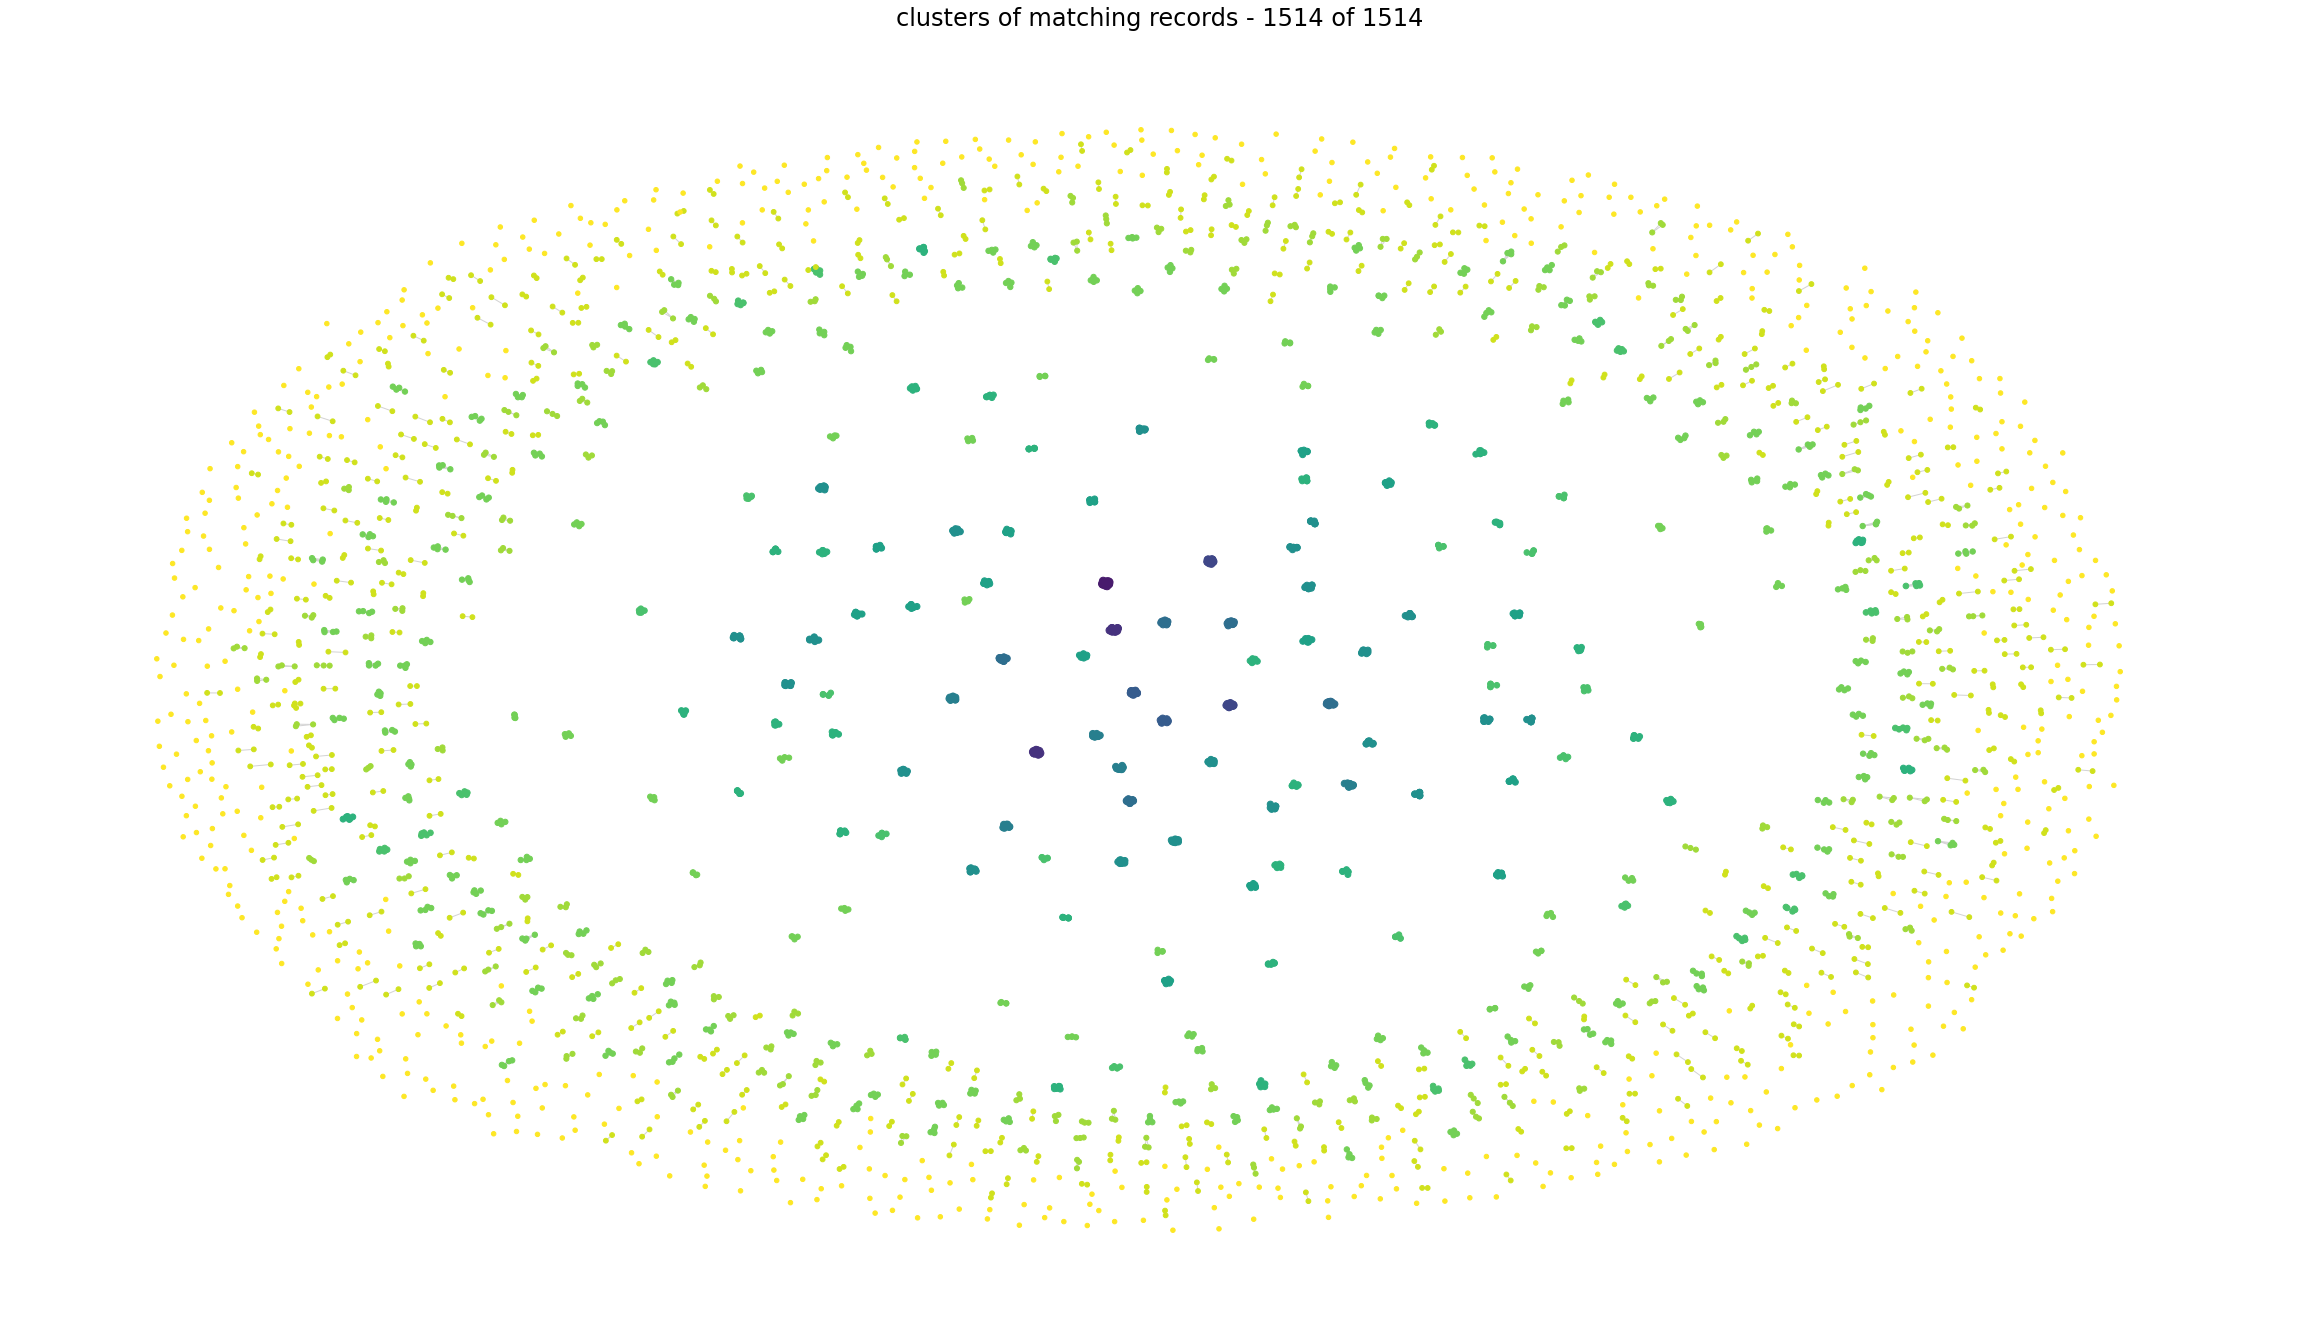

In [24]:
subset_length = cluster_count
title = f'clusters of matching records - {subset_length} of {cluster_count}'
plot_cluster_graph(cluster_graph(df, subset_length), title)

We can also visualise this as an adjacency matrix

In [25]:
def plot_record_matrix(g, title):
    matrix = nx.to_numpy_array(g, weight='confidence')
    plt.figure(figsize=(8,6))
    plt.imshow(matrix, cmap='inferno')
    plt.colorbar(label='mean confidence in cluster')
    plt.title(title)
    plt.xlabel('first record id in pair')
    plt.ylabel('second record id in pair')
    plt.show()

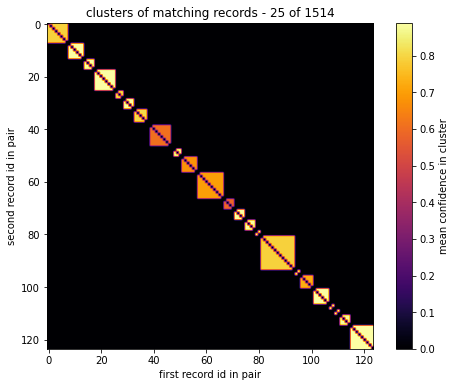

In [26]:
subset_length = 25
title = f'clusters of matching records - {subset_length} of {cluster_count}'
plot_record_matrix(cluster_graph(df, subset_length), title)

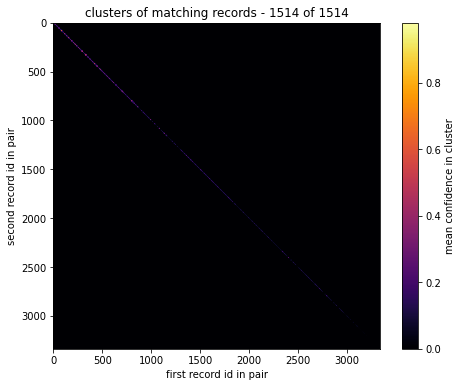

In [27]:
subset_length = cluster_count
title = f'clusters of matching records - {subset_length} of {cluster_count}'
plot_record_matrix(cluster_graph(df, subset_length), title)

Author: David Colls